# Hate Speech Detector - PL - Dense model

In [1]:
import os
import pandas as pd
import csv
import glob
import numpy as np
import pickle
from klepto.archives import dir_archive

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

## Load features & labels

In [2]:
archive = dir_archive('hsd/Poleval2019/X_y_dense', {}, cached=True)
archive.load()

features = archive['features']
labels = archive['labels']

In [3]:
features.shape

(11041, 8016)

## Model

The best model was selected using a GridSearch with 5-fold CV.

In [4]:
# hyperparams
LAYERS = 2  # hidden layers count
LR = 0.01  # learning rate
OPTIM = tf.keras.optimizers.Adam  # optimizer
EPOCHS = 15

# params
HL_NODES = 64  # hidden layer nodes
BATCH_SIZE = 200  # size of input batch
INIT = 'random_normal'  # trainable param initializer

In [5]:
SPLIT_RATIO = 0.7

In [6]:
X_train = features[:int(SPLIT_RATIO*len(features))]
y_train = labels[:int(SPLIT_RATIO*len(labels))]
X_test = features[int(SPLIT_RATIO*len(features)):]
y_test = labels[int(SPLIT_RATIO*len(labels)):]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('Train x: {}'.format(len(X_train)))
print('Train y: {}'.format(len(y_train)))
print('Test x: {}'.format(len(X_test)))
print('Test y: {}'.format(len(y_test)))

Train x: 7728
Train y: 7728
Test x: 3313
Test y: 3313


In [7]:
class MetricsCallback(Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()
        self.val_f1s0 = []
        self.val_f1s1 = []
    
    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.asarray(tf.argmax(self.model.predict(X_test), axis=1))
        val_true = np.asarray(tf.argmax(y_test, axis=1))
        c_m = confusion_matrix(val_true, val_predict, labels=[0, 1])
        self.val_f1s0.append(2*float(c_m[0][0])/(2*float(c_m[0][0]) + c_m[0][1] + c_m[1][0]))
        self.val_f1s1.append(2*float(c_m[1][1])/(2*float(c_m[1][1]) + c_m[1][0] + c_m[0][1]))

In [8]:
class DenseModel():
    def __init__(self, input_shape, name='dense_model', **kwargs):
        # hyperparams
        self.layers = LAYERS if 'layers' not in kwargs else kwargs['layers']
        self.lr = LR if 'lr' not in kwargs else kwargs['lr']
        self.optim = OPTIM(learning_rate=self.lr) if 'optim' not in kwargs else kwargs['optim'](learning_rate=self.lr)
        self.epochs = EPOCHS if 'epochs' not in kwargs else kwargs['epochs']
        
        # params
        self.hl_nodes = HL_NODES if 'hl_nodes' not in kwargs else kwargs['hl_nodes']
        self.batch_size = BATCH_SIZE if 'batch_size' not in kwargs else kwargs['batch_size']
        self.init = INIT if 'init' not in kwargs else kwargs['init']
        
        # layers
        inputs = Input(shape=input_shape, name='features')
        x = Dense(self.hl_nodes, activation='relu', name='dense_1',
                  kernel_initializer=self.init, bias_initializer=self.init)(inputs)
        for layer in range(self.layers)[1:]:
            x = Dense(self.hl_nodes, activation='relu', name='dense_{}'.format(layer+1),
                      kernel_initializer=self.init, bias_initializer=self.init)(x)
        outputs = Dense(2, activation='softmax', name='predictions',
                        kernel_initializer=self.init, bias_initializer=self.init)(x)
        
        self.name = name
        self.model = Model(inputs=inputs, outputs=outputs, name=name)
        self.mc = MetricsCallback()
    
    def summary(self):
        return self.model.summary()
    
    def compile(self):
        self.model.compile(optimizer=self.optim,
                           loss=tf.keras.losses.CategoricalCrossentropy(),
                           metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    def fit(self, X_tr, y_tr, X_ev, y_ev):
        return self.model.fit(X_tr, y_tr, batch_size=self.batch_size, epochs=self.epochs,
                              validation_data=(X_ev, y_ev), callbacks=[self.mc])
    
    def predict(self, X_t):
        return self.model.predict(X_t)
    
    def save(self, file_name):
        self.model.save(file_name)

In [9]:
def models_comparison_bars(df, title, interval=2, save_file=None):
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    
    labels = [i+1 if i%interval == 0 else '' for i in range(len(df))]
    x = range(len(labels))
    acc = df['acc'].values
    f1s0 = df['f1s0'].values
    f1s1 = df['f1s1'].values
    
    max_acc_id = np.argmax(acc)
    max_f1s0_id = np.argmax(f1s0)
    max_f1s1_id = np.argmax(f1s1)
    
    axs[0].bar(x, acc, color='r')
    axs[0].set_xlabel('Model number')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(labels)
    axs[0].set_ylim([0, 1])
    axs[0].set_title('Accuracy | max ({}) at: {}'.format(np.round(np.max(acc), 2), max_acc_id+1))
    axs[0].patches[max_acc_id].set_facecolor('g')
    
    axs[1].bar(x, f1s0, color='b')
    axs[1].set_xlabel('Model number')
    axs[1].set_ylabel('F1 score (no hate)')
    axs[1].set_title('F1 score (no hate) | max ({}) at: {}'.format(np.round(np.max(f1s0), 2), max_f1s0_id+1))
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(labels)
    axs[1].set_ylim([0, 1])
    axs[1].patches[max_f1s0_id].set_facecolor('g')
    
    axs[2].bar(x, f1s1, color='m')
    axs[2].set_xlabel('Model number')
    axs[2].set_ylabel('F1 score (hate speech)')
    axs[2].set_title('F1 score (hate speech) | max ({}) at: {}'.format(np.round(np.max(f1s1), 2),
                                                                       max_f1s1_id+1))
    axs[2].set_xticks(x)
    axs[2].set_xticklabels(labels)
    axs[2].set_ylim([0, 1])
    axs[2].patches[max_f1s1_id].set_facecolor('g')
    
    fig.suptitle(title)
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

## Model hyperparams researching

In [10]:
layers_options = [2, 5, 8]
lr_options = [0.1, 0.01, 0.001]
optim_options = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD]
epochs_options = [5, 10, 15]

hp_options = []
for epochs in [epochs_options[-1]]:  # changed to process 15 epochs (eval. after each 5)
    for lr in lr_options:
        for optim in optim_options:
            for layer in layers_options:
                hp_options.append({'lr': lr, 'optim': optim, 'epochs': epochs, 'layers': layer})

In [11]:
pd.DataFrame(hp_options).head()

,epochs,layers,lr,optim
0,15,2,0.1,<class 'tensorflow.python.keras.optimizer_v2.a...
1,15,5,0.1,<class 'tensorflow.python.keras.optimizer_v2.a...
2,15,8,0.1,<class 'tensorflow.python.keras.optimizer_v2.a...
3,15,2,0.1,<class 'tensorflow.python.keras.optimizer_v2.g...
4,15,5,0.1,<class 'tensorflow.python.keras.optimizer_v2.g...


In [12]:
if not os.path.exists('results/pl_dense/hyperparams_research.csv'):
    hp_results = []
    for i, opts in enumerate(hp_options):
        print('\nResearching for {}/{} | Hyperparams: {}\n'.format(i+1, len(hp_options), opts))

        hp_model = DenseModel(input_shape=(8016, ), **opts)
        hp_model.compile()
        hp_history = hp_model.fit(X_train, y_train, X_test, y_test)

        # append means for 5, 10 and 15 epochs
        for eps in epochs_options:
            hp_results.append({'acc': np.mean(hp_history.history['categorical_accuracy'][:eps]),
                               'val_acc': np.mean(hp_history.history['val_categorical_accuracy'][:eps]),
                               'loss': np.mean(hp_history.history['val_loss'][:eps]),
                               'f1s0': np.mean(hp_model.mc.val_f1s0[:eps]),
                               'f1s1': np.mean(hp_model.mc.val_f1s1[:eps])})
    
    hp_results_df = pd.DataFrame(hp_results)
    hp_results_df.to_csv('results/pl_dense/hyperparams_research.csv')
else:
    hp_results_df = pd.read_csv('results/pl_dense/hyperparams_research.csv', index_col=0)

In [13]:
hp_results_df.head()

,acc,f1s0,f1s1,loss,val_acc
0,0.951630,0.952265,0.601681,0.285456,0.915545
1,0.956910,0.956555,0.668592,0.252505,0.923694
2,0.955486,0.953030,0.603340,0.280402,0.916772
3,0.935093,0.917143,0.000000,8.976652,0.846967
4,0.936620,0.917143,0.000000,11.891177,0.846967


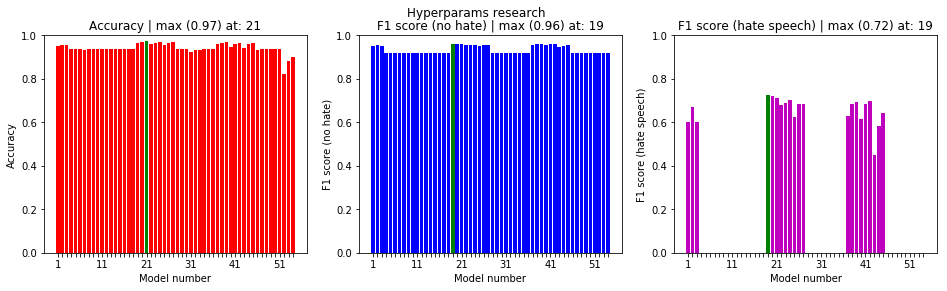

In [14]:
models_comparison_bars(hp_results_df, title='Hyperparams research', interval=10,
                       save_file='results/pl_dense/hyperparams_research.png')

In [15]:
best_h_num = 19
'Best one: {} with {} run epochs'.format(hp_options[(best_h_num-1)/3],
                                         ((best_h_num-1)%3)*5 if (best_h_num-1)%3 != 0 else 15)

"Best one: {'optim': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'epochs': 15, 'lr': 0.01, 'layers': 2} with 15 run epochs"

## Model params researching

In [16]:
hl_nodes_options = [64, 128]
batch_size_options = [100, 200]
init_options = ['random_uniform', 'random_normal']

p_options = []
for hl_nodes in hl_nodes_options:
    for batch_size in batch_size_options:
        for init in init_options:
            p_options.append({'hl_nodes': hl_nodes, 'batch_size': batch_size, 'init': init})

In [17]:
pd.DataFrame(p_options).head()

,batch_size,hl_nodes,init
0,100,64,random_uniform
1,100,64,random_normal
2,200,64,random_uniform
3,200,64,random_normal
4,100,128,random_uniform


In [18]:
if not os.path.exists('results/pl_dense/params_research.csv'):
    p_results = []
    for i, opts in enumerate(p_options):
        print('\nResearching for {}/{} | Params: {}\n'.format(i+1, len(p_options), opts))

        p_model = DenseModel(input_shape=(8016, ), **opts)
        p_model.compile()
        p_history = p_model.fit(X_train, y_train, X_test, y_test)

        p_results.append({'acc': np.mean(p_history.history['categorical_accuracy']),
                          'val_acc': np.mean(p_history.history['val_categorical_accuracy']),
                          'loss': np.mean(p_history.history['val_loss']),
                          'f1s0': np.mean(p_model.mc.val_f1s0),
                          'f1s1': np.mean(p_model.mc.val_f1s1)})
    
    p_results_df = pd.DataFrame(p_results)
    p_results_df.to_csv('results/pl_dense/params_research.csv')
else:
    p_results_df = pd.read_csv('results/pl_dense/params_research.csv', index_col=0)

In [19]:
p_results_df.head()

,acc,f1s0,f1s1,loss,val_acc
0,0.969746,0.955632,0.675214,0.239297,0.922004
1,0.972438,0.960063,0.717536,0.230148,0.930053
2,0.969850,0.956630,0.681780,0.229274,0.923715
3,0.971273,0.960744,0.731127,0.223136,0.931542
4,0.972162,0.960253,0.722398,0.240864,0.930496


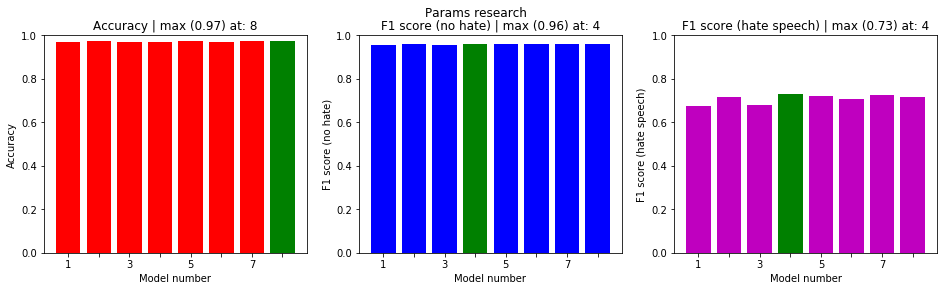

In [20]:
models_comparison_bars(p_results_df, title='Params research', interval=2,
                       save_file='results/pl_dense/params_research.png')

In [21]:
best_num = 4
'Best one: {}'.format(p_options[best_num-1])

"Best one: {'hl_nodes': 64, 'init': 'random_normal', 'batch_size': 200}"

## Best model

In [22]:
model = DenseModel(input_shape=(8016, ))
model.summary()

Model: "dense_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, 8016)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                513088    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
predictions (Dense)          (None, 2)                 130       
Total params: 517,378
Trainable params: 517,378
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile()
history = model.fit(X_train, y_train, X_test, y_test)
model.save('models/pl_dense.model')

Train on 7728 samples, validate on 3313 samples
Epoch 1/15
7728/7728 [==============================] - 2s 219us/sample - loss: 0.1664 - categorical_accuracy: 0.9506 - val_loss: 0.1712 - val_categorical_accuracy: 0.9360
Epoch 2/15
7728/7728 [==============================] - 1s 118us/sample - loss: 0.0941 - categorical_accuracy: 0.9662 - val_loss: 0.1877 - val_categorical_accuracy: 0.9354
Epoch 3/15
7728/7728 [==============================] - 1s 107us/sample - loss: 0.0836 - categorical_accuracy: 0.9696 - val_loss: 0.1971 - val_categorical_accuracy: 0.9405
Epoch 4/15
7728/7728 [==============================] - 1s 121us/sample - loss: 0.0766 - categorical_accuracy: 0.9687 - val_loss: 0.2779 - val_categorical_accuracy: 0.9088
Epoch 5/15
7728/7728 [==============================] - 1s 106us/sample - loss: 0.0728 - categorical_accuracy: 0.9713 - val_loss: 0.1658 - val_categorical_accuracy: 0.9366
Epoch 6/15
7728/7728 [==============================] - 1s 106us/sample - loss: 0.0670 - cat

In [24]:
predictions = model.predict(X_test)
y_true = tf.argmax(y_test, axis=1)
y_pred = tf.argmax(predictions, axis=1)

conf_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred, num_classes=2).numpy()
acc = float(np.sum(np.diag(conf_mat)))/np.sum(np.sum(conf_mat))
f1s0 = 2*float(conf_mat[0][0])/(2*float(conf_mat[0][0]) + conf_mat[0][1] + conf_mat[1][0])
f1s1 = 2*float(conf_mat[1][1])/(2*float(conf_mat[1][1]) + conf_mat[1][0] + conf_mat[0][1])

In [25]:
if not os.path.exists('results/pl_dense/short_results.csv'):
    with open('results/pl_dense/short_results.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Accuracy', 'F1 score (0)', 'F1 score (1)'])
        writer.writerow([acc, f1s0, f1s1])
else:
    with open('results/pl_dense/short_results.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([acc, f1s0, f1s1])

In [26]:
# save model history, confusion matrix and accuracy
model_results = {'acc': history.history['categorical_accuracy'],
                 'val_acc': history.history['val_categorical_accuracy'],
                 'loss': history.history['loss'],
                 'val_loss': history.history['val_loss'],
                 'f1s0': model.mc.val_f1s0,
                 'f1s1': model.mc.val_f1s1,
                 'conf_mat': conf_mat,
                 'main_acc': acc}
with open('results/pl_dense/results.pkl', 'w') as f:
    pickle.dump(model_results, f)

## Visualizations

In [27]:
def plots(y_ss, y_labels, colors, title, file_name=None):
    x_s = range(1, len(y_ss[0])+1)
    for y_s, y_label, color in zip(y_ss, y_labels, colors):
        plt.plot(x_s, y_s, color, label=y_label)
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    tick_marks = np.arange(1, len(x_s) + 1)
    plt.xticks(tick_marks, x_s)
    plt.title(title)
    
    plt.legend(loc='best', frameon=False)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

def twinx_plot(y11_s, y12_s, y21_s, y22_s, x_label, y1_label,y2_label, title,
               styles=['r-', 'r--', 'b-', 'b--'], colors=['r', 'b'], file_name=None):
    fig, ax1 = plt.subplots()
    
    ax1.set_xlabel(x_label)
    ax1.set_xticks(range(1, len(y11_s)+1))
    
    ax1.set_ylabel(y1_label, color=colors[0])
    ax1.plot(range(1, len(y11_s)+1), y11_s, styles[0], label='train acc.')
    ax1.plot(range(1, len(y12_s)+1), y12_s, styles[1], label='valid. acc.')
    ax1.tick_params(axis='y', labelcolor=colors[0])
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    ax2.set_ylabel(y2_label, color=colors[1])  # we already handled the x-label with ax1
    ax2.plot(range(1, len(y21_s)+1), y21_s, styles[2], label='train loss')
    ax2.plot(range(1, len(y22_s)+1), y22_s, styles[3], label='valid. loss')
    ax2.tick_params(axis='y', labelcolor=colors[1])
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.legend(loc='right', bbox_to_anchor=(0.85, 0.5))
    plt.title(title)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

def confusion_matrix_plot(conf_mat, cls, x_label, y_label, title, file_name=None):
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    tick_marks = np.arange(len(cls))
    plt.grid(False)
    plt.xticks(tick_marks, cls, rotation=45)
    plt.yticks(tick_marks, cls)
    
    for i in range(len(cls)):
        for j in range(len(cls)):
            plt.text(j - 0.2, i, str(conf_mat[i][j]), fontsize=16)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

def class_distribution_hist(y_true, y_pred, cls, x_label, y_label, title, file_name=None):
    pd.Series([y_true, y_pred]).hist()
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    tick_marks = np.arange(len(cls))
    plt.xticks(tick_marks, cls)
    plt.legend(labels=['Real', 'Predicted'], loc='best')
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

In [28]:
classes = ['no hate', 'hate speech']

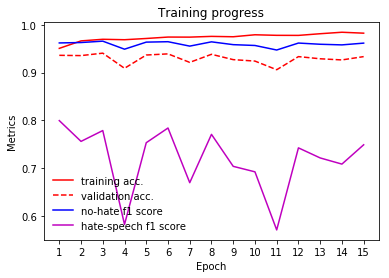

In [29]:
plots([history.history['categorical_accuracy'],
       history.history['val_categorical_accuracy'],
       model.mc.val_f1s0,
       model.mc.val_f1s1],
      ['training acc.', 'validation acc.', 'no-hate f1 score', 'hate-speech f1 score'],
      ['-r', '--r', 'b', 'm'],
      title='Training progress', file_name='results/pl_dense/train_progress.png')

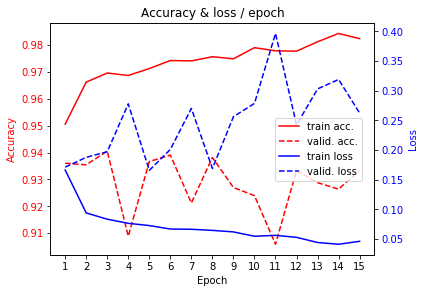

In [30]:
twinx_plot(history.history['categorical_accuracy'], history.history['val_categorical_accuracy'],
           history.history['loss'], history.history['val_loss'],
          x_label='Epoch', y1_label='Accuracy', y2_label='Loss', title='Accuracy & loss / epoch',
          file_name='results/pl_dense/acc_loss.png')

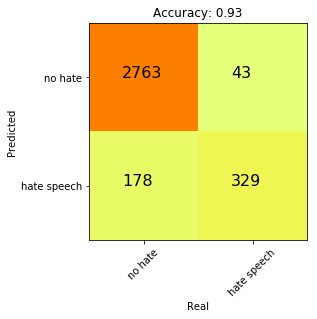

In [31]:
confusion_matrix_plot(conf_mat, cls=classes,
                      x_label='Real', y_label='Predicted',
                      title='Accuracy: {}'.format(round(acc, 2)),
                      file_name='results/pl_dense/cm.png')

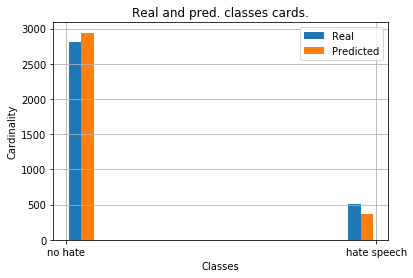

In [32]:
class_distribution_hist(y_true, y_pred, cls=classes,
                        x_label='Classes', y_label='Cardinality', title='Real and pred. classes cards.',
                        file_name='results/pl_dense/cards.png')

In [74]:
with open('hsd/Poleval2019/perfect_data.pkl', 'r') as f:
    texts, _ = pickle.load(f)
texts = texts[int(SPLIT_RATIO*len(texts)):]

indices = [6, 10, 19, 26, 27, 28, 29, 164]
test_cases = []
for i, (t, p, l) in enumerate(zip(texts, y_pred, y_true)):
    if i in indices:
        test_cases.append({'Text': t, 'Prediction': p.numpy(), 'Label': l.numpy()})

In [75]:
def test_cases_board(test_cases, title, file_name=None):
    h = 20
    n = len(test_cases)
    fig, axis = plt.subplots(1, 1, figsize=(16., n*3.2))
    axis.axis('off')
    axis.set_xlim([0, 100])
    axis.set_ylim([0, n*h])
    axis.plot([0, 100], [0, 0], color='k')
    axis.plot([0, 0], [0, n*h], color='k')
    axis.plot([100, 100], [0, n*h], color='k')
    
    for i in range(n):
        axis.annotate('Tweet text:', xy=(4, 16 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        text = u'{}'.format(test_cases[i]['Text'].decode('utf-8').replace('\n', ''))
        text = '\n'.join([text[j:j+len(text)/3] for j in range(0, len(text), len(text)/3)])
        axis.annotate(text, xy=(4, 7 + i*h), xycoords='data', size=15)
        
        axis.annotate('Prediction:', xy=(4, 4 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        pred = 'no hate' if test_cases[i]['Prediction'] == 0 else 'hate speech'
        pred_color = 'b' if pred == 'no hate' else 'm'
        axis.annotate(pred, xy=(15, 4 + i*h), xycoords='data', size=15, color=pred_color)
        
        axis.annotate('Label:', xy=(27, 4 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        label = 'no hate' if test_cases[i]['Label'] == 0 else 'hate speech'
        label_color = 'b' if label == 'no hate' else 'm'
        axis.annotate(label, xy=(34, 4 + i*h), xycoords='data', size=15, color=label_color)
        
        axis.annotate('Result:', xy=(50, 4 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        reason = 'OK' if pred == label else '1-st type error' if pred == 'no hate' else '2-nd type error'
        reason_color = 'g' if reason == 'OK' else 'r'
        axis.annotate(reason, xy=(57, 4 + i*h), xycoords='data', size=15, color=reason_color)
        
        axis.plot([0, 100], [20 + i*h, 20 + i*h], color='k')
    
    
    plt.title(title)
    if file_name:
        plt.savefig(file_name)
    plt.show()

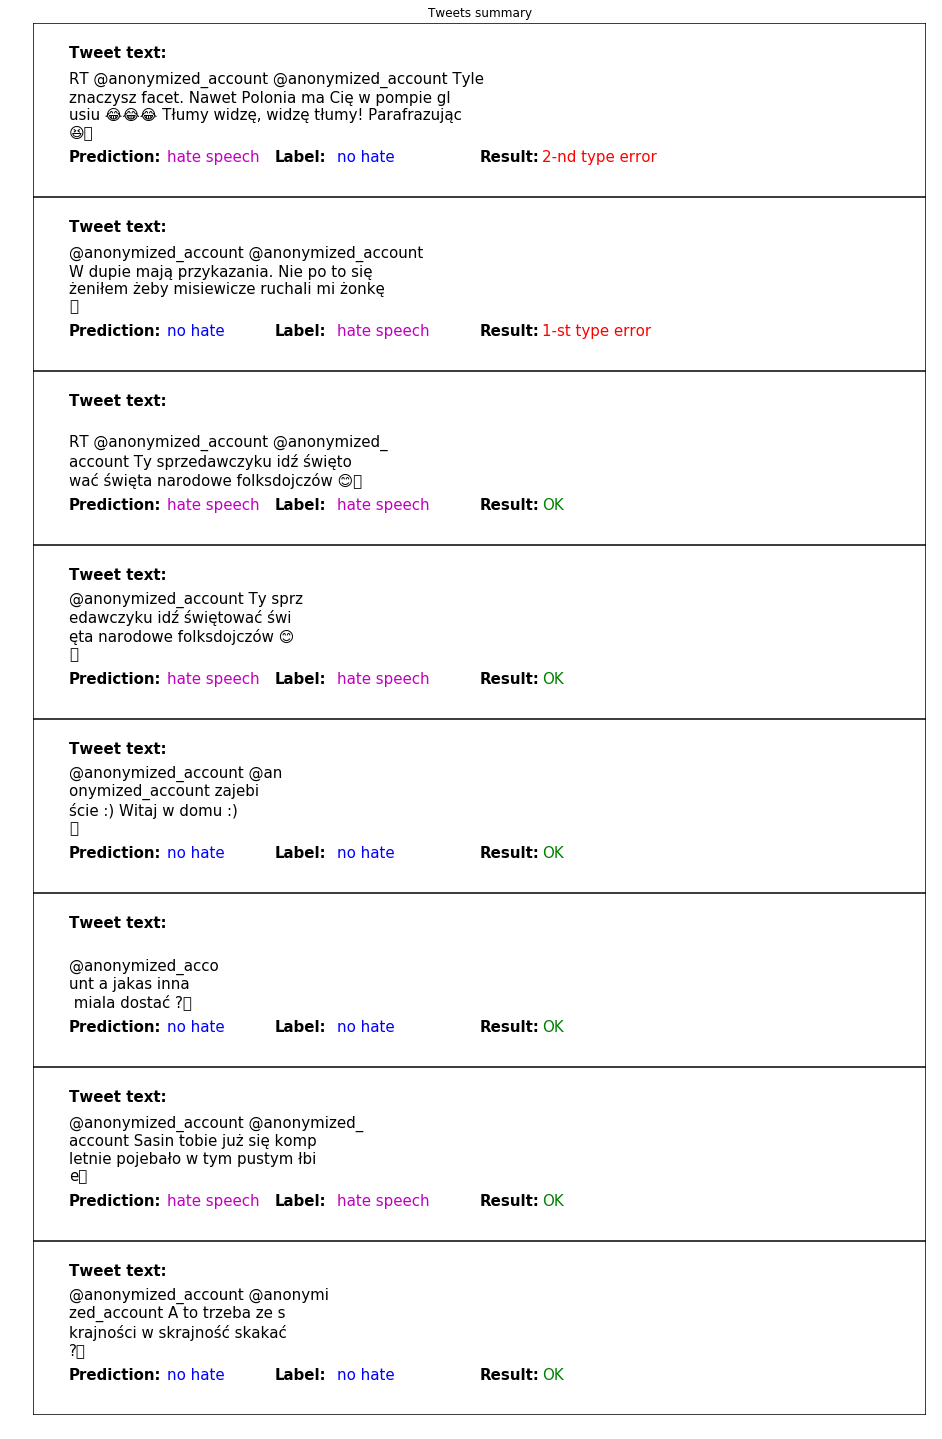

In [76]:
test_cases_board(test_cases, title='Tweets summary', file_name='results/pl_dense/tweets_summary.png')

# Hate Speech Detector - PL - Dense model testing

## Load test features, predict classes, assign tweets and save to .csv

In [35]:
with open('tests/pl_dense/assigned_labels.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Label'])
    
    t = tqdm(sorted(glob.glob('tests/pl_dense/X*')))
    for file_name in t:
        t.set_postfix_str(file_name)
        archive = dir_archive(file_name, {}, cached=True)
        archive.load()

        test_features = archive['features']
        
        test_predictions = model.predict(test_features)
        test_labels = tf.argmax(test_predictions, axis=1).numpy()
        
        for tl in test_labels:
            writer.writerow([tl])